### Canadidan election

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import re
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import nltk
from pylab import rcParams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn import preprocessing as prep
import seaborn as sns
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
sentiment = pd.read_csv('sentiment_analysis.csv')
election = pd.read_csv('Canadian_elections_2021.csv')

In [3]:
## def function
# remove the html tags and attributes (/<>)
def html_tags_attributes(df):
    text=BeautifulSoup(df,'html.parser')
    return text.get_text()

In [4]:
## apply 到DF


In [5]:
sentiment['text'] = sentiment["text"].apply(html_tags_attributes)
election['text'] = election["text"].apply(html_tags_attributes)

In [6]:
## remove the HTML character code are replaced by ASCII equivalent

def html_ASCII(df):
    text_remove = html.unescape(df)
    return text_remove

In [7]:
sentiment['text'] = sentiment["text"].apply(html_ASCII)
election['text'] = election["text"].apply(html_ASCII)

In [8]:
## remove the URL

def urls(df):
    df=re.sub(r"http\S+",'', df)
    return df

In [9]:
sentiment['text'] = sentiment["text"].apply(urls)
election['text'] = election["text"].apply(urls)

In [10]:
## how to lower the text
def lower_case(df):
    df = df.lower()
    return df

In [33]:
election['text'] = election['text'].apply(lower_case)
sentiment['text'] = sentiment["text"].apply(lower_case)

In [34]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ningcansun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
election['text'] = election['text'].apply(lambda x: ' '.join([i for i in x.split()if i not in (stop_words)]))
sentiment['text']= sentiment['text'].apply(lambda x: ' '.join([i for i in x.split() if i not in (stop_words)]))

In [36]:
##emoji removed

def emoji(df):
    moji = re.compile( "["
        u"\U0001F300-\U0001F5FF"  # symbols
        u"\U0001F600-\U0001F64F"  # face emotion
        u"\U0001F1E0-\U0001F1FF"  # flags (because it is elections, so there must lots of people use canada's flag)
        u"\U0001F680-\U0001F6FF"  # map
         "]+",re.UNICODE)
    return re.sub(moji,'',df)

In [37]:
election['text'] = election['text'].apply(emoji)
sentiment['text'] = sentiment['text'].apply(emoji)

# EDA

In [38]:
sentiment

,ID,text,label
0,7.680980e+17,josh jenkins looking forward tab breeders crow...,1
1,7.680980e+17,rt @mianusmanjaved: congratulations pakistan b...,1
2,7.680980e+17,"rt @pepalerts: september, @yesmag taking maine...",1
3,7.680980e+17,"rt @david_gaibis: newly painted walls, thanks ...",1
4,7.680980e+17,rt @cedricfeschotte: excited announce: july 20...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o can't stop watching her...mm. mor...,0
550387,8.046180e+17,poor old tom odell look like would know wrong ...,0
550388,8.046180e+17,#antsmasher smashed 7 ants awesome game!!!hjfjfi,1
550389,8.046180e+17,@lizhudston @kymwyllie @evasmiless @meanbok @l...,1


In [39]:
election

,text,sentiment,negative_reason
0,"canadian election power grab pm trudeau, yes -...",negative,calling election early
1,hope trudeau loses canadian election tomorrow ...,negative,covid
2,"dear canadians, election test progressive are....",positive,NaN
3,canadian friends: never forget trudeau 2 years...,negative,calling election early
4,sorry @thejagmeetsingh voted #ndp life electio...,positive,NaN
...,...,...,...
997,absolutely horrible canada. forthcoming electi...,negative,others
998,@davidakin trudeau imposes gun control policie...,negative,gun control
999,canada election stolen thugs. uneducated goons...,negative,others
1000,"o'toole amends platform gun control, questions...",negative,tell lies


In [40]:
# I want to set some key words to represent the political parties
# Use the for loop to find the whether each tweet text include the following keywords.
# If it include in the keywords, then, append them in that party.
def political_party(tweet_text):
    final_party=[]
    liberal_party=['justin','trudeau','liberal','liberalism','istandwithtrudeau','voteliberal']
    conservative_party=['erin','toole','voteconservative','blue','cpc','conservative']
    new_democratic_party=['ndp','ndp2021','ndpoverhaul','jagmeet','singh','jagmeetsingh','newdemocratic']
    people_party=['ppc','voteppc','voteppc2021','maxime','bernier','maximebernier','people']
    
    # I have already set the blank list, which is'final_party', next to add in the blank list
    for i in tweet_text:
        if i in liberal_party:
            final_party.append('liberal party')
            ### print("detected")
        if i in conservative_party:
            final_party.append('conservative party')
        if i in new_democratic_party:
            final_party.append('new democratic party')
        if i in people_party:
            final_party.append('ppc party')
    # However, it may have one tweet mention more than one party groups. Then I need to select the first party
    # The reason I choose the first mention party because the political that people more care about, the people will mention first
    if len(final_party)>=1:
        final_result=final_party[0]
    # if there is no key word match to parties, then, return the 'not sure'  
    if len(final_party)==0:
        final_result = 'not sure'
    
    return final_result

In [41]:
election_temp = election.copy()
election_temp['text'] = election_temp['text'].str.split(' ')

In [42]:
political_party(election_temp['text'] )

'not sure'

In [43]:
election_temp['political_party'] = ''


In [44]:
for i in range(election_temp['text'].shape[0]):
    election_temp['political_party'][i] = political_party(election_temp['text'][i])

In [45]:
counts_political=pd.DataFrame(election_temp['political_party'].value_counts())


In [46]:
counts_political

,political_party
not sure,595
liberal party,252
conservative party,69
ppc party,60
new democratic party,26


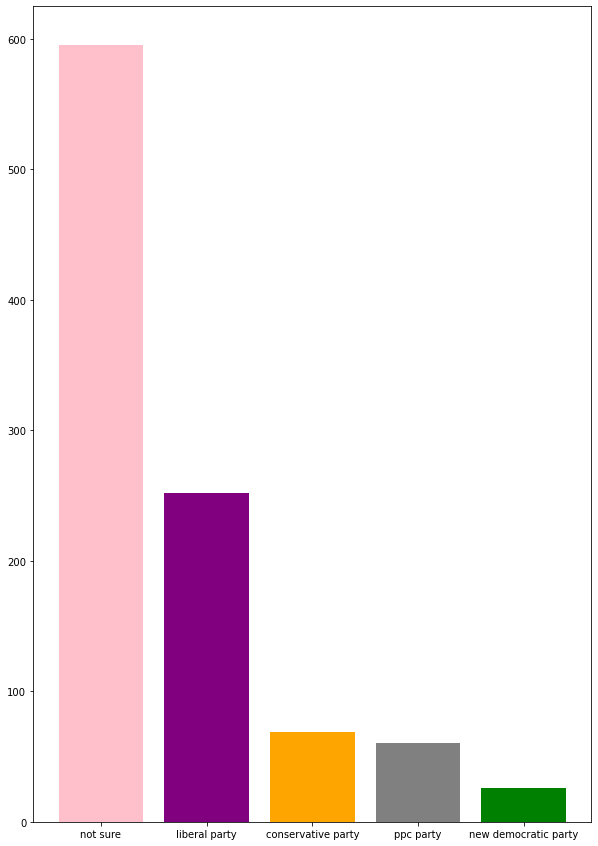

In [49]:
plt.bar(counts_political.index,counts_political.political_party,color = ['pink','purple','orange','gray','green'])
rcParams['figure.figsize']=(10,15)

In [51]:
# through hashtag to find some information  #如何用# 去找一些information - 比如什么hashtag他们提到的更多

#baba #lala

temp_111 = sentiment['text']
temp_list= temp_111.str.split('#')
temp_1=[]
for i in temp_list.keys():
    temp_1 +=temp_list[i][1:]
    
temp_list_liberal = pd.Series(temp_1)
all_hashtag_sentiment = temp_list_liberal.value_counts()

In [54]:
hash_top10_sentiment=pd.DataFrame(all_hashtag_sentiment).head(10)
hash_top10_sentiment

,0
trecru,14184
pushawardskathniels,964
pjnet,773
hiring,667
quote,623
love,573
funny,505
sex,486
job,486
nationaldogday,449


In [55]:
positive_negative = pd.DataFrame(election['sentiment'].value_counts())
positive_negative

,sentiment
positive,615
negative,387


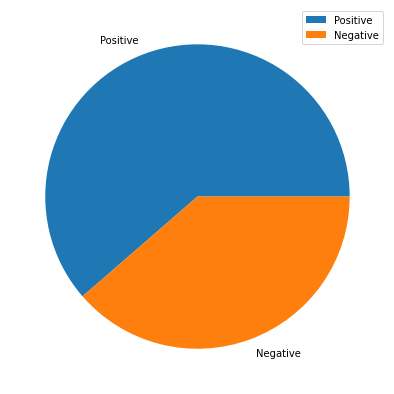

In [57]:
labels =['Positive','Negative']
plt.pie(positive_negative['sentiment'],labels=labels)
plt.legend()
plt.gcf().set_size_inches(7,7)

In [58]:
negative_reason = election['negative_reason'].value_counts()
negative_reason = pd.DataFrame(negative_reason)
negative_reason.head()

,negative_reason
others,149
calling election early,73
tell lies,61
covid,25
economy,20


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

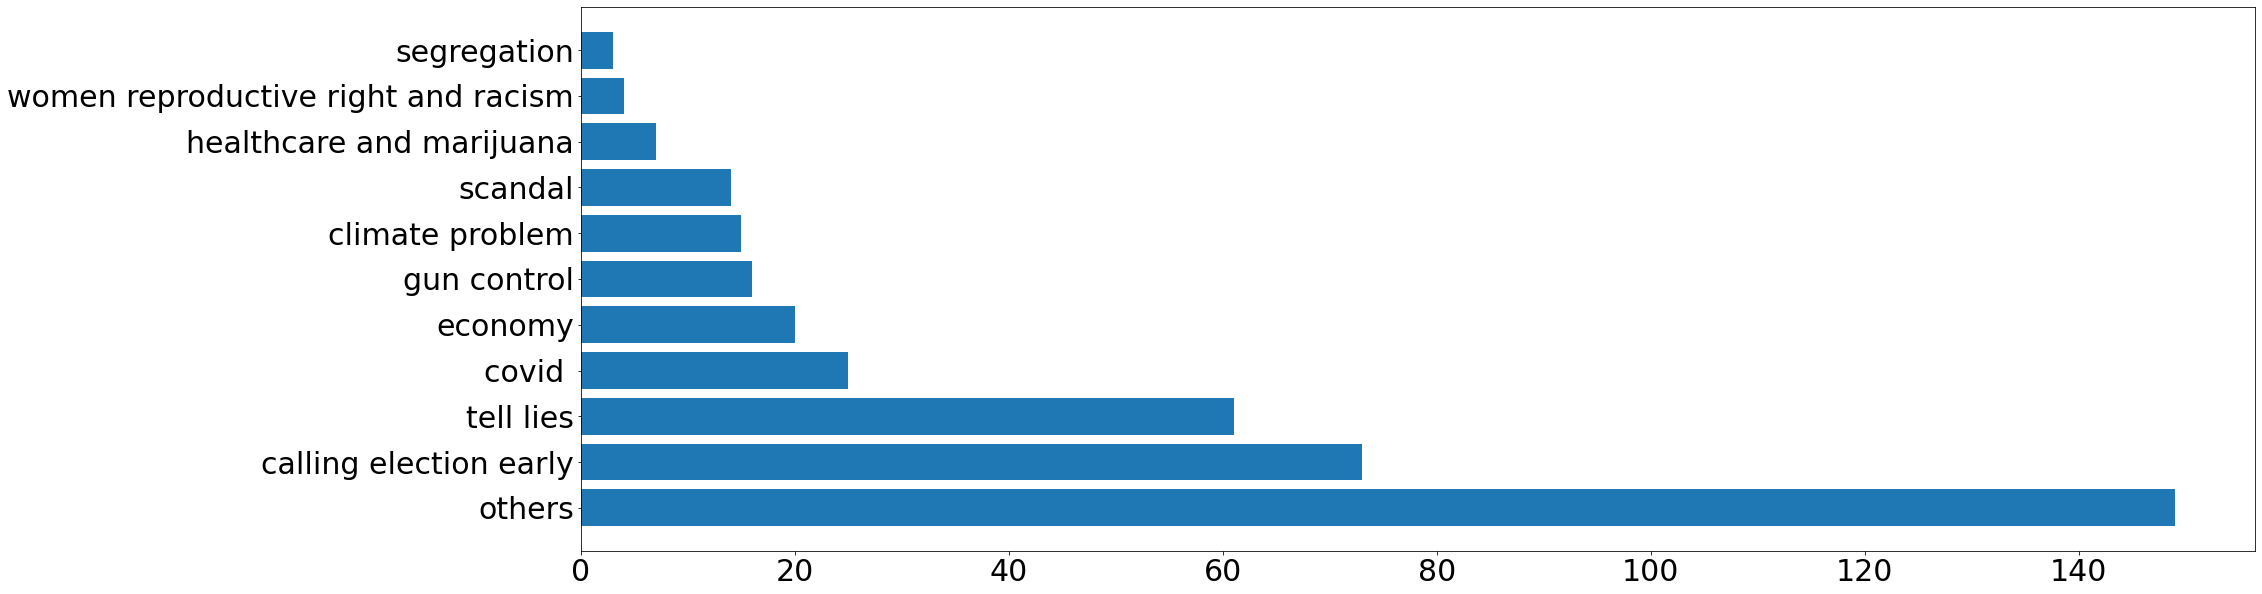

In [60]:
plt.barh(negative_reason.index,negative_reason['negative_reason'])
rcParams['figure.figsize']=(30, 10)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


# Model

In [62]:
X=sentiment['text'].copy()
y=sentiment['label'].copy()

In [66]:
## split, train_size 一定要占比大一点， test size 占比。 ---》 因为我们要花更多的data去训练模型
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7, test_size = 0.3)

In [70]:
# Bag of words Feature --- 一定要看懂

bag_of_words = CountVectorizer()
X_train_word = bag_of_words.fit_transform(X_train)
X_test_word = bag_of_words.transform(X_test)


In [71]:
## TF-IDF
tf_idf = TfidfVectorizer()
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [ ]:
# logistic regression

In [72]:
### bag of words in Logistic regression

logis = LogisticRegression()
logis.fit(X_train_word, y_train)

/Users/ningcansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [74]:
# 我们用X_train_word  和y_train 建立的模型 然后去预测X_test_word  的y值与真实的y的区别
train_prediction_word_logis = logis.predict(X_train_word)
test_prediction_word_logis = logis.predict(X_test_word)
# we already predict the y 

In [76]:
# find the accuracy of the true Y_train and the predict y
ACC_train_word_logis = accuracy_score(y_train, train_prediction_word_logis)*100
ACC_train_word_logis

98.74816039535602

In [77]:
## 65% - 75% 都是好的 
### 90% + overfiting
### 65% - underfiting
ACC_test_word_logis = accuracy_score(y_test, test_prediction_word_logis)*100
ACC_test_word_logis

97.48482903135938

In [78]:
### tf-idf
logis = LogisticRegression()
logis.fit(X_train_tf,y_train)


/Users/ningcansun/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [82]:
train_prediction_tf_logis = logis.predict(X_train_tf)
test_prediction_tf_logis = logis.predict(X_test_tf)

In [83]:
ACC_train_tf_logis = accuracy_score(y_train, train_prediction_tf_logis)*100
ACC_train_tf_logis

98.00167673312171

In [84]:
ACC_test_tf_logis = accuracy_score(y_test, test_prediction_tf_logis)*100
ACC_test_tf_logis

97.23712738768639

In [85]:
#KNN
knn=KNeighborsClassifier()
knn.fit(X_train_word,y_train)

KNeighborsClassifier()

In [ ]:
train_prediction_word_knn = knn.predict(X_train_word)
test_prediction_word_knn = knn.predict(X_test_word)

In [ ]:
ACC_train_word_knn = accuracy_score(y_train, train_prediction_word_knn)*100
ACC_train_word_knn

In [ ]:
ACC_test_word_knn = accuracy_score(y_test, test_prediction_word_knn)*100
ACC_test_word_knn

In [87]:
# Naive Bayes

In [88]:
nb = MultinomialNB()
nb.fit(X_train_word, y_train)

MultinomialNB()

In [ ]:
# SVM

In [89]:
svm = LinearSVC()
svm.fit(X_train_word, y_train)

LinearSVC()

In [ ]:
# decision tree

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train_word,y_train)

In [ ]:
# random forest

In [ ]:
rf = RandomForestClassifier()